In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io
from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
#from bokeh.io import save, show, output_file, output_notebook, reset_output, export_png
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh import palettes
from bokeh.models.callbacks import CustomJS
from bokeh.models.widgets import Div
from bokeh.layouts import widgetbox, row, column
from bokeh.models import (
    GeoJSONDataSource, ColumnDataSource, ColorBar,  Spacer,
    HoverTool, TapTool, Panel, Tabs, Legend, Toggle, LegendItem,
)
from collections import Counter
%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import plotly.graph_objects as go

In [2]:
df = pd.read_csv(r"C:\Users\Suwani Gunasekara\OneDrive\Documents\Sem 7 ML\Mid term\results.csv")

In [3]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
df.shape

(42082, 9)

In [5]:
# take matches which are only in not neutral places
df = df.loc[df.neutral == False].reset_index()

In [6]:
def get_results(row):
    if row['home_score'] == row['away_score']:
        val = 0
    elif row['home_score'] > row['away_score']:
        val = 1
    elif row['home_score'] < row['away_score']:
        val = -1
    else:
        val = 99
    return val

In [7]:
df['result'] = df.apply(get_results, axis = 1)

In [8]:
# count the number of home wins, away wins and draws
rslts  = df['result'].value_counts().sort_values(ascending = True )

In [9]:
rslts

 0     7339
-1     8388
 1    15997
Name: result, dtype: int64

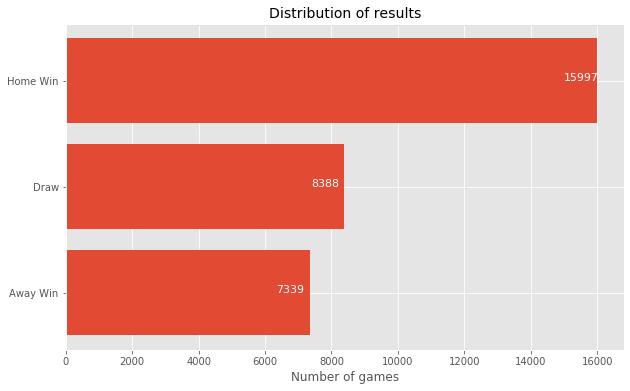

In [10]:
# drawing 

# Set figure size
plt.rcParams["figure.figsize"] = (10,6)

# Create a horizontal bar graph to visualize distribution of results
fig, ax = plt.subplots()

# Create labels
lbls1 = ['Away Win', 'Draw', 'Home Win']
y_pos = np.arange(len(lbls1))

# Set chart parameters

ax.barh(y_pos, rslts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(lbls1)

ax.set_xlabel('Number of games')
ax.set_title('Distribution of results', size = 14)



for i, v in enumerate(rslts):
    ax.text(v - 1000, i, str(v),  fontsize='11', color = "white")

plt.show()


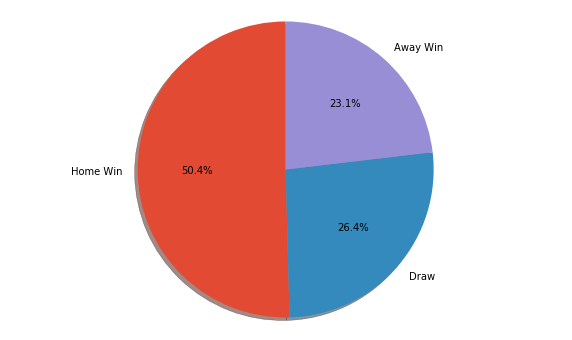

In [11]:
fig1, ax1 = plt.subplots()
ax1.pie(df['result'].value_counts(), labels = ["Home Win","Draw","Away Win"], startangle=90, autopct='%.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We see that out of 31724 total matches, 50.4% are home wins, 26.4% are draws and 23.1% are away wins. 
On average it is twice as likely for a home team to win as the away team for a randomly selected game

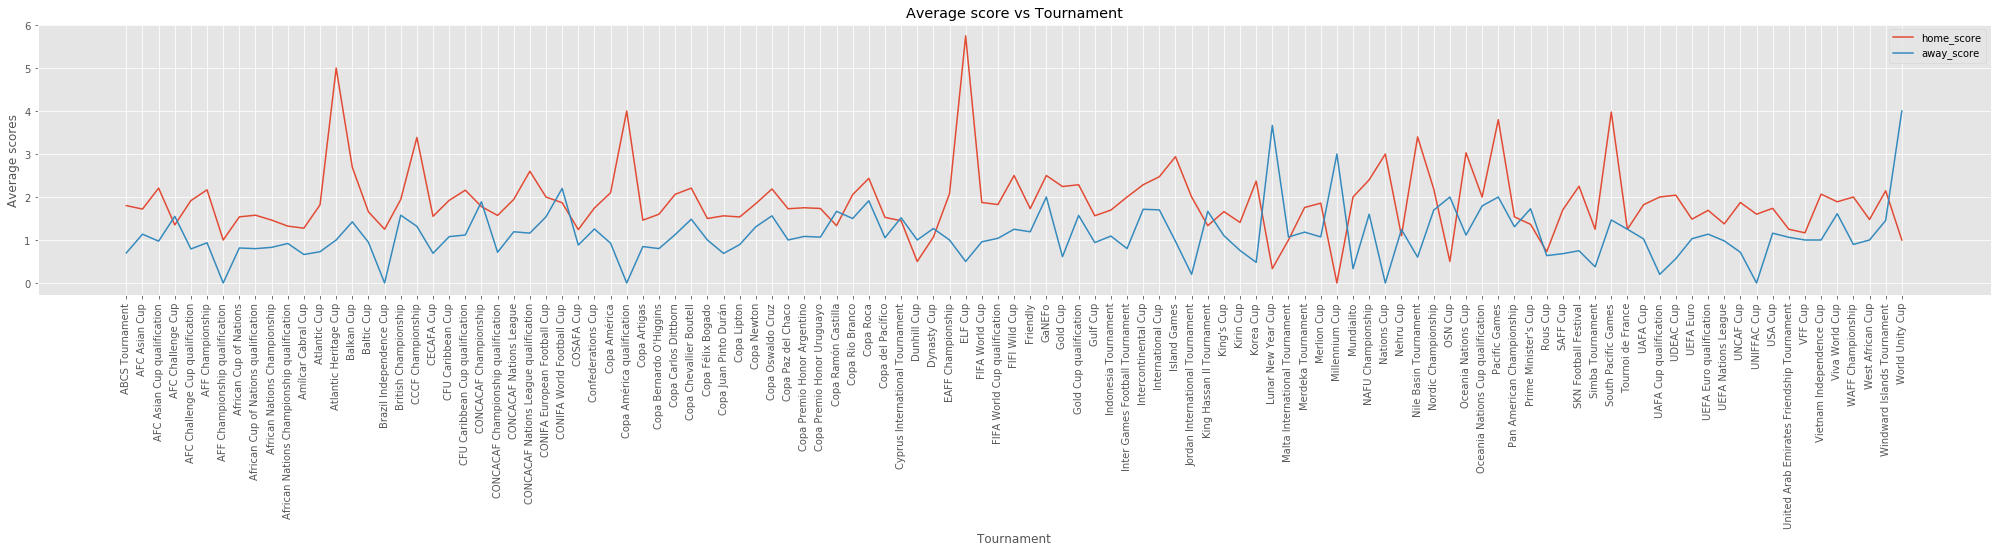

In [12]:
dfhome = df.groupby(['tournament'])['home_score'].mean().to_frame().reset_index()
dfaway = df.groupby(['tournament'])['away_score'].mean().to_frame().reset_index()
dfscoreaverage = dfhome.merge(dfaway,how = 'inner', on = 'tournament', )

plt.figure(figsize = (35,5))
plt.plot(dfscoreaverage.tournament,dfscoreaverage.home_score, label = "home_score" )
plt.plot(dfscoreaverage.tournament,dfscoreaverage.away_score, label = "away_score")

plt.title("Average score vs Tournament")
plt.xlabel("Tournament")
plt.xticks(rotation = 90)
plt.ylabel("Average scores")
plt.legend()

plt.show()

Above plot represent the avearge score of the home team and the average score of the away team for each of the tournaments.
The blue line shows the mean score of home team while the orange line shows the mean score of the away team. The blue line is almost always above the orange line. This means that the home team score better than the away team.

##### Now lets see how major teams have performed when they are the home team and when they are the away team

In [13]:
def HomeWon(row):
    if(row['home_score']>row['away_score']):
        return row.home_team
    else:
        return 0
df['HomeWon'] = df.apply(HomeWon, axis = 1)

def AwayWon(row):
    if(row['home_score']< row['away_score']):
        return row.away_team
    else:
        return 0
df['AwayWon'] = df.apply(AwayWon, axis = 1)


In [14]:
df.head()

,index,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result,HomeWon,AwayWon
0,0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,0,0,0
1,1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1,England,0
2,2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1,Scotland,0
3,3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,0,0,0
4,4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1,Scotland,0


In [15]:
# Calculating the number of home wins for each country
# Converting df column to list
listwonHome = df.HomeWon.values.tolist()
dictWonHome = dict(Counter(listwonHome))
#del dictWonHome[0]
#dictWonHome

In [16]:
# Calculating the number of away wins for each country
dictWonAway = dict(Counter(df.AwayWon.values.tolist()))
del dictWonAway[0]

In [17]:
# Calculating the number of all wins for each country
allWon = dict(Counter(dictWonHome)+ Counter(dictWonAway))

In [18]:
dfhomewon = pd.DataFrame(dictWonHome.items(), columns = ['Country','HomeWins'])
dfawaywon = pd.DataFrame(dictWonAway.items(), columns = ['Country','AwayWins'])
dfallwon = pd.DataFrame(allWon.items(), columns = ['Country','AllWins'])

dfall = dfhomewon.merge(dfawaywon, how = 'inner', on = 'Country')
dfall = dfall.merge(dfallwon, how = 'inner', on = 'Country')

In [19]:
dfall.head()

,Country,HomeWins,AwayWins,AllWins
0,England,292,247,539
1,Scotland,214,149,363
2,Wales,122,85,207
3,United States,215,60,275
4,Northern Ireland,104,56,160


The top 3 football teams are based on 2020 rankings,
    1. Belgium      
    2. France  
    3. Brazil 
Let's see how these three teams have performed throught the years 

In [20]:
dftopteam2020 = dfall[dfall['Country'].isin(['Belgium','France','Brazil'])]
dftopteam2020.head()

,Country,HomeWins,AwayWins,AllWins
7,France,256,123,379
8,Belgium,202,109,311
22,Brazil,246,164,410


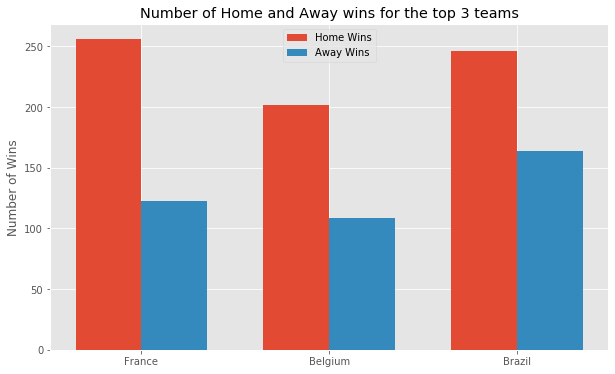

In [21]:
N = 3
ind = np.arange(N)

width = 0.35
plt.bar(ind, dftopteam2020.HomeWins, width, label = 'Home Wins')
plt.bar(ind+width, dftopteam2020.AwayWins, width, label = 'Away Wins' )

plt.ylabel("Number of Wins")
plt.title("Number of Home and Away wins for the top 3 teams")
plt.xticks(ind+width/2, ('France','Belgium','Brazil'))
plt.legend(loc = 'best')
plt.show()

In all three teams, the number of home wins is higher than the number of away wins.

##### What is the impact on home team winning based on the country which the game is hosted

In [22]:
countrylist = df.country.unique().tolist()

In [23]:
#https://dashee87.github.io/data%20science/python/home-advantage-in-football-leagues-around-the-world/
def get_home_team_advantage(model_goals_df,pval = 0.05):
    
    #extract relavant columns
    #model_goals_df = goals_df[['HomeTeam','AwayTeam','FTHG','FTAG']]
    # rename goal columns
    #model_goals_df = model_goals_df.rename(columns = {'FTHG':'HomeGoals','FTAG':'AwayGoals'})
    
     # reformat dataframe for the model
    goal_model_data = pd.concat([model_goals_df[['home_team','away_team','home_score']].assign(home=1).rename(
                columns={'home_team':'team', 'away_team':'opponent','home_score':'goals'}),
               model_goals_df[['away_team','home_team','away_score']].assign(home=0).rename(
                columns={'away_team':'team', 'home_team':'opponent','away_score':'goals'})])
    
    # build poisson model
    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit(method="lbfgs")
    # output model parameters
    poisson_model.summary()
    
    #return poisson_model.summary()
    return np.concatenate((np.array([poisson_model.params['home']]), 
                    poisson_model.conf_int(alpha=pval).values[-1]))
    

In [24]:
#dfEngland = df.loc[df.country == 'England'].reset_index()
#dfEngland.head()
#get_home_team_advantage(dfEngland)

In [41]:
# getting year column to get matches happend after 2000
newdate = df['date'].str.split("-",n=3, expand = True)
df['Year'] = newdate[0].astype(int)
df2000 = df.loc[df.Year >= 2000]

In [118]:
#advantagedict2000 = {}
advantagedictall = {}
for country in countrylist:
    dfcountry = df.loc[df.country == country].reset_index()
    homeadvantage = get_home_team_advantage(dfcountry)[0]
    advantagedictall[country] = math.exp(homeadvantage)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihoo

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inve

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1093: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Max

PerfectSeparationError: Perfect separation detected, results not available

In [119]:
#advantagedictall

{'Scotland': 3.4435277795278734,
 'England': 1.5388479368221673,
 'Wales': 3.8401247967218572,
 'Republic of Ireland': 3.0255149528974776,
 'United States': 1.7376633693612427,
 'Uruguay': 1.1217783612129644,
 'Austria': 2.3971846965107577,
 'Hungary': 3.3978407854663093,
 'Argentina': 4.465183666073744,
 'Belgium': 1.6718829047641064,
 'France': 0.3694114887975177,
 'Netherlands': 1.6837992120976872,
 'Bohemia': 0.010785472254102386,
 'Switzerland': 0.34797750820131285,
 'Sweden': 0.2884542678234762,
 'Germany': 0.7729047898106226,
 'Italy': 1.1579273156392627,
 'Chile': 0.9378470243797193,
 'Norway': 0.96759529508285,
 'Finland': 0.9708555238174073,
 'Luxembourg': 0.8427969484302756,
 'Russia': 1.7580310920334032,
 'Denmark': 2.3073033040749724,
 'Spain': 1.0252999729952668,
 'Japan': 5.87369346495055,
 'Brazil': 1.2902172125995812,
 'Paraguay': 1.0004525779425628,
 'Canada': 1.4331244592158772,
 'Estonia': 0.9082766333416962,
 'Guatemala': 6.516936296171259,
 'Czechoslovakia': 1.328

In [114]:
advantagedict2 = advantagedict.copy()
#advantagedict1 = advantagedictall.copy()

In [85]:
# combine the score of scotland england and wales
advantagedict1['United Kindom'] = (advantagedict1['Scotland'] + advantagedict1['England'] + advantagedict1['Wales']+advantagedict1['Northern Ireland'])/4
del advantagedict1['Scotland']
del advantagedict1['England']
del advantagedict1['Wales']
del advantagedict1['Northern Ireland']

advantagedict1['Ireland'] = (advantagedict1['Republic of Ireland'] + advantagedict1['Irish Free State']+advantagedict1['Éire'])/3
del advantagedict1['Republic of Ireland']
del advantagedict1['Irish Free State']

advantagedict1['France'] = (advantagedict1['France'] + advantagedict1['Guadeloupe']+ advantagedict1['French Guiana']+ advantagedict1['Martinique']+ advantagedict1['French Somaliland']) /5
del advantagedict1['Guadeloupe']
del advantagedict1['French Guiana']
del advantagedict1['Martinique']
del advantagedict1['French Somaliland']

advantagedict1['Netherlands'] = (advantagedict1['Netherlands'] + advantagedict1['Netherlands Guyana'] + advantagedict1['Curaçao'])/3
del advantagedict1['Netherlands Guyana']
del advantagedict1['Curaçao']


advantagedict1['Czech Republic'] = (advantagedict1['Bohemia'] + advantagedict1['Bohemia and Moravia'])/2
del advantagedict1['Bohemia']
del advantagedict1['Bohemia and Moravia']

advantagedict1['China'] = (advantagedict1['China PR'] + advantagedict1['Manchuria'])/2
del advantagedict1['China PR']
del advantagedict1['Manchuria']




In [86]:
#advantagedict['Northern Ireland']

In [87]:
advantagedf = pd.DataFrame(advantagedict1.items(), columns = ['Country','Advantage'])

In [26]:
# to get the country codes
world_gdp = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv")
world_gdp = world_gdp[['COUNTRY','CODE']]
world_gdp.columns = ['Country','CODE']
#world_gdpdict = world_gdp.set_index('COUNTRY').T.to_dict('list')
#.to_dict('records')

In [106]:
mapall = advantagedf.merge(world_gdp, how = 'outer' , on ='Country' ) 
#mpall.to_csv(r'"C:\Users\Suwani Gunasekara\OneDrive\Documents\Sem 7 ML\Mid term\results.csv"')

In [107]:
# fill missing value with zero
mapall = mapall.fillna(0)

In [120]:
mapall.loc[mapall.Country == 'Bohemia']

,Country,Advantage,CODE


In [109]:
mapall.loc[mapall.CODE == 0]

,Country,Advantage,CODE
25,Czechoslovakia,1.328918,0
27,Yugoslavia,3.859334,0
37,Soviet Union,0.720956,0
46,British Guyana,50.363860,0
57,Éire,0.001963,0
61,Palestine,1.296865,0
64,Southern Rhodesia,0.560963,0
68,Northern Rhodesia,29.108893,0
69,Tanganyika,0.001691,0
72,United Kindom,2.715917,0


In [110]:
# renaming countries
#df.at['Republic of Ireland',Country] = 'Ireland'
#df.at['Bohemia',Country] = 'Czech Republic'
#df.at['Czechoslovakia',Country] = 'Socialist Federal Republic of Yugoslavia'
#mapall.at['Soviet Union','Country'] = 'Russia'
mapall.iloc[37,0] = 'Russia'
#df.at['China PR',Country] = 'China'
#mapall.at['British Guyana','Country'] = 'Guyana'
mapall.iloc[46,0] = 'Guyana'
#mapall.at['Southern Rhodesia', 'Country'] = 'Zimbabwe'
mapall.iloc[64, 0] = 'Zimbabwe'
#mapall.at['Northern Rhodesia', 'Country'] = 'Zambia'
mapall.iloc[68,0] = 'Zambia'

#mapall.at['Tanganyika', 'Country'] = 'Tanzania'
mapall.iloc[72,0] = 'Tanzania'




In [111]:
mapallnew = mapall.loc[mapall.CODE != 0]

In [112]:
mapallnew

,Country,Advantage,CODE
0,United States,1.737663,USA
1,Uruguay,1.121778,URY
2,Austria,2.397185,AUT
3,Hungary,3.397841,HUN
4,Argentina,4.465184,ARG
...,...,...,...
227,Virgin Islands,0.000000,VGB
228,West Bank,0.000000,WBG
229,Yemen,0.000000,YEM
230,Zambia,0.000000,ZMB


In [ ]:
advantagedf2020 = pd.DataFrame(advantagedict1.items(), columns = ['Country','Advantage'])

In [113]:
fig = go.Figure(data = go.Choropleth(
    locations = mapallnew['CODE'],
    z = mapallnew['Advantage'],
    text = mapallnew['Country'],
    colorscale = 'earth',
    autocolorscale = False,
    reversescale = True, 
    marker_line_color = 'white',
    marker_line_width = 0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Advantage'))

fig.show()

In [116]:
advantagedf2020 = pd.DataFrame(advantagedict.items(), columns = ['Country','Advantage'])
mapall = advantagedf.merge(world_gdp, how = 'outer' , on ='Country' ) 
# fill missing value with zero
mapall = mapall.fillna(0)
mapall.loc[mapall.CODE == 0]

,Country,Advantage,CODE
25,Czechoslovakia,1.328918,0
27,Yugoslavia,3.859334,0
37,Soviet Union,0.720956,0
46,British Guyana,50.363860,0
57,Éire,0.001963,0
61,Palestine,1.296865,0
64,Southern Rhodesia,0.560963,0
68,Northern Rhodesia,29.108893,0
69,Tanganyika,0.001691,0
72,United Kindom,2.715917,0
